In [7]:
%load_ext autoreload
%autoreload 2
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.qua import *
from qm import SimulationConfig
import numpy as np
import matplotlib.pyplot as plt
config = {
    "version": 1,
    "controllers": {
        "con1": {
            "type": "opx1",
            "analog_outputs": {
                1: {"offset": +0.0},
                2: {"offset": +0.0},
            },
        }
    },
    "elements": {
        "qe1": {
            "singleInput": {"port": ("con1", 1)},
            "intermediate_frequency": 5e6,
            "operations": {
                "playOp": "constPulse",
            },
        },
        "qe2": {
            "singleInput": {"port": ("con1", 2)},
            "intermediate_frequency": 5e6,
            "operations": {
                "playOp": "constPulse",
            },
        },
    },
    "pulses": {
        "constPulse": {
            "operation": "control",
            "length": 1000,  # in ns
            "waveforms": {"single": "const_wf"},
        },
    },
    "waveforms": {
        "const_wf": {"type": "constant", "sample": 0.2},
    },
}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Flow control

### For loop

In [8]:
with program() as prog:
    idx = declare(int)
    a = declare(int)
    with for_(idx,0,idx<10,idx+1):
        assign(a,a+1)
        save(a,"a")
    
    

QMm = QuantumMachinesManager()
QMm.close_all_quantum_machines()

QM1 = QMm.open_qm(config)
job = QM1.simulate(prog, SimulationConfig(int(1000)))  # in clock cycles, 4 ns
res=job.result_handles

a = res.a.fetch_all()['value']

print(f"\nThe program returned the value: a={a}")

2021-04-01 14:03:09,146 - qm - INFO - Performing health check
2021-04-01 14:03:09,167 - qm - INFO - Health check passed
2021-04-01 14:03:09,185 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-01 14:03:09,193 - qm - INFO - Flags: 
2021-04-01 14:03:09,194 - qm - INFO - Simulating Qua program

The program returned the value: a=[ 1  2  3  4  5  6  7  8  9 10]


### While loop

In [9]:
with program() as prog:
    a = declare(int)
    with while_(a<10):
        assign(a,a+1)
        save(a,"a")
    
    

QMm = QuantumMachinesManager()
QMm.close_all_quantum_machines()

QM1 = QMm.open_qm(config)
job = QM1.simulate(prog, SimulationConfig(int(1000)))  # in clock cycles, 4 ns
res=job.result_handles

a = res.a.fetch_all()['value']

print(f"\nThe program returned the value: a={a}")

2021-04-01 14:03:10,372 - qm - INFO - Performing health check
2021-04-01 14:03:10,377 - qm - INFO - Health check passed
2021-04-01 14:03:10,399 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-01 14:03:10,410 - qm - INFO - Flags: 
2021-04-01 14:03:10,411 - qm - INFO - Simulating Qua program

The program returned the value: a=[ 1  2  3  4  5  6  7  8  9 10]


### Conditional: If and cond

QUA implements an `if - else` which works as you expect: 

In [24]:
with program() as prog:
    a = declare(int)
    with while_(a<10):
        assign(a,a+1)
        with if_(a==4):
            save(a,"a")
        with else_():
            save(0,"a")
            
    
    

QMm = QuantumMachinesManager()
QMm.close_all_quantum_machines()

QM1 = QMm.open_qm(config)
job = QM1.simulate(prog, SimulationConfig(int(1000)))  # in clock cycles, 4 ns
res=job.result_handles

a = res.a.fetch_all()['value']



print(f"\nThe program returned the value: a={a}")

2021-04-01 09:51:06,204 - qm - INFO - Performing health check
2021-04-01 09:51:06,210 - qm - INFO - Health check passed
2021-04-01 09:51:06,213 - qm - WARNING - Client's version (0.90.690) does not match the server version (0.91.781).
2021-04-01 09:51:06,235 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-01 09:51:06,245 - qm - INFO - Flags: 
2021-04-01 09:51:06,246 - qm - INFO - Simulating Qua program

The program returned the value: a=[0 0 0 4 0 0 0 0 0 0]


**Util.cond** : There is another opetion to implement simple conditional. The `Util.cond` function is an efficient implementation of the conditional which can speed up operations in some cases:

In [21]:
with program() as prog:
    a = declare(int,value=0)
    b = declare(int,value=10)
    with while_(a<100):
        assign(a,Util.cond(a == b, a+10000,a+1))
        save(a,"a")
            
    
    

QMm = QuantumMachinesManager()
QMm.close_all_quantum_machines()

QM1 = QMm.open_qm(config)
job = QM1.simulate(prog, SimulationConfig(int(1000)))  # in clock cycles, 4 ns
res=job.result_handles

a = res.a.fetch_all()['value']

print(f"\nThe program returned the value: a={a}")

2021-04-01 09:10:28,945 - qm - INFO - Performing health check
2021-04-01 09:10:28,952 - qm - INFO - Health check passed
2021-04-01 09:10:28,956 - qm - WARNING - Client's version (0.90.690) does not match the server version (0.91.781).
2021-04-01 09:10:28,981 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-01 09:10:28,997 - qm - INFO - Flags: 
2021-04-01 09:10:28,999 - qm - INFO - Simulating Qua program

The program returned the value: a=[    1     2     3     4     5     6     7     8     9    10 10010]


### Conditionally playing pulses

A final conditional usage option is integrated into the play statment itself. By passing a condition to the `play` we play the pulse when a = 0 .. 4 but not for the rest of the loop values. 

2021-04-01 14:19:09,916 - qm - INFO - Performing health check
2021-04-01 14:19:09,929 - qm - INFO - Health check passed
2021-04-01 14:19:09,962 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-01 14:19:09,986 - qm - INFO - Flags: 
2021-04-01 14:19:09,987 - qm - INFO - Simulating Qua program

The program returned the value: a=[0 1 2 3 4 5 6 7 8 9]


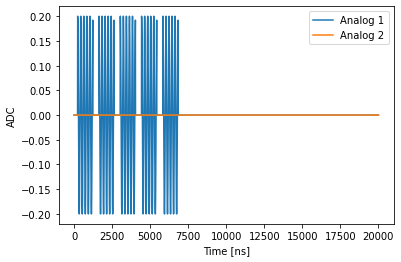

In [18]:
with program() as prog:
    a = declare(int,value=0)
    with for_(a,0,a<10,a+1):
        play('playOp','qe1',condition=(a<5))
        wait(100,'qe1')
        save(a,"a")

QMm = QuantumMachinesManager()
QMm.close_all_quantum_machines()

QM1 = QMm.open_qm(config)
job = QM1.simulate(prog, SimulationConfig(int(5000)))  # in clock cycles, 4 ns
res=job.result_handles

a = res.a.fetch_all()['value']

print(f"\nThe program returned the value: a={a}")



samples = job.get_simulated_samples()
samples.con1.plot()

## Excercises

1. write a program to play two pulses, with delay of 100 cycles between them, repreated 100 times